<a href="https://colab.research.google.com/github/stefanocostantini/pytorch-book/blob/master/ch8_using_convolutions_to_generalise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data

We re-create the same datasets which we used in the previous chapter

In [ ]:
import torch
from torchvision import transforms

In [ ]:
## Download files locally
!mkdir /content/cifar10/
from torchvision import datasets
data_path_for_saving = '/content/cifar10/'
cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=True)

Extracting /content/cifar10/cifar-10-python.tar.gz to /content/cifar10/
Files already downloaded and verified


In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                  transform=transforms.ToTensor())
tensor_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                      transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([item_t for item_t, _ in tensor_cifar10], dim = 3)
reshaped = imgs.view(3,-1) # keep the first dimension, squash all others into a single dim
print(reshaped.shape)

means = reshaped.mean(dim=1) # mean of the first dimension (i.e. the three channels)
stds = reshaped.std(dim=1)

torch.Size([3, 51200000])


In [ ]:
# Now we have the information to do the normalisation, as follows.
# Note that we `compose` transformations together
transformed_cifar10 = datasets.CIFAR10(data_path_for_saving, train=True, download=False,
                                       transform = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

transformed_cifar10_val = datasets.CIFAR10(data_path_for_saving, train=False, download=False,
                                       transform = transforms.Compose([
                                         transforms.ToTensor(),
                                         transforms.Normalize((means[0], means[1], means[2]),
                                                              (stds[0], stds[1], stds[2]))                              
                                       ]))

In [ ]:
# We just want to keep class 0 and 2. Remember that the __getitem__ method returns
# both the item and its label
class_mapping = {0: 0, 2: 1}

cifar2 = [(item, class_mapping[label])
          for item, label in tensor_cifar10 if label in [0,2]]
cifar2_val = [(item, class_mapping[label])
          for item, label in tensor_cifar10_val if label in [0,2]] 

## Intro to convolutions

_**Note:** We now have the same datasets as before (`cifar2` and `cifar2_val`) at our disposal._

_**Note 2:** my focus for this chapter is on how to subclass the `nn` module, hence will cover convolutions only at a high level._

Convolutions are needed to deliver locality and translation invariance.

Convolutions for a 2D image are the scalar (dot) product of a weight matrix (the _kernel_) with every neighbourhood in the input.

So, if we have kernel as follows:

```
weight = torch.tensor([[w00, w01, w02],
                       [w10, w11, w12],
                       [w20, w21, w22]])
```
and  a 1-channel MxN image:
```
image = torch.tensor([[i00, i01, i02, i03, ..., i0N],
                      [i10, i11, i12, i13, ..., i1N],
                      [i20, i21, i22, i23, ..., i2N],
                      [i30, i31, i32, i33, ..., i3N],
                      ...
                      [iM0, iM1m iM2, iM3, ..., iMN]])
```
The the output at, say, `1,1` can be calculated as follows (without bias):
```
o11 = i11 * w00 + i12 * w01 + i13 * w02 +
      i21 * w10 + i22 * w11 + i23 * w12 +
      i31 * w20 + i32 * w21 + i33 * w22
```
By repeating this calculation for each input of the image (i.e. by translating the kernel on all input locations) we obtain an output image where each location will be expressed as a weighted sum of its immediate vicinity (depending on the size of the kernel).

Note that we do not know the weights in advance: these are randomly initialised at the beginning and then learned through model training. Note also that the same weights are using across the whole image, so they have a history spanning the entire image. Thus, the derivative of the loss with respect to a convolution weight includes contributions from the entire image.

This also mean that we have many fewer parameters compared with a fully connected model which accepts 1D inputs. The number of parameters will no longer depend on the number of pixels in the image, but rather on:
- the size of the convolution kernel
- how many convolution filters (or output channels) there are

## Using convolutions

The `torch.nn` module provides convolutions for 1, 2 and 3 dimensions: `nn.Conv1D` for time series (and text), `nn.Conv2D` for images and `nn.Conv3D` for volumes or video. 

To `nn.Conv2D` we need to provide the following arguments:
- the number of input features (or channels, as there will be more than 1 value per pixel)
- the number of output features
- the size of the kernel.

In [19]:
from torch import nn

In [21]:
# In our case we have 3 channels, so the input features will be 3. We choose an
# arbitrary output of 16 features and a 3x3 kernel
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [23]:
# And these are the dimensions of weight and bias
conv.weight.shape, conv.bias.shape
# 16 output features, 3 input features (channel) and a 3x3 kernel. 

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [25]:
# Let's apply the convolution to one of the images in the dataset and compare it
# with the original one. Let's get the image first:
img, _ = cifar2[0]

# Need to add the zero-th batch dimension
output = conv(img.unsqueeze(0))

# Let's check the dimensions - it looks like we've lost 2 pixels from each dimension...
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

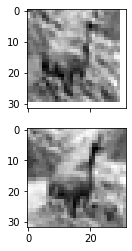

In [45]:
# Displaying the two images reveals what has happened:
from matplotlib import pyplot as plt 
f, axarr = plt.subplots(2, sharex=True, sharey=True)
axarr[0].imshow(output[0,0].detach(), cmap='gray')
axarr[1].imshow(img[0].detach(), cmap='gray')
plt.show()

In [46]:
# We can prevent this from happening by having some padding, which uses `ghost` pixels
# on the sides of the image.
conv_padded = nn.Conv2d(3,16, kernel_size=3, padding=1)
output_padded = conv_padded(img.unsqueeze(0))
img.unsqueeze(0).shape, output_padded.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

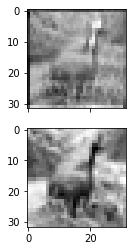

In [47]:
f, axarr = plt.subplots(2, sharex=True, sharey=True)
axarr[0].imshow(output_padded[0,0].detach(), cmap='gray')
axarr[1].imshow(img[0].detach(), cmap='gray')
plt.show()

A way to make sure the convolutions can really pick up the salient features of an image, is to put these through some downsampling, so that only the "strongest" features, i.e. the features that better characterise an image would survive.

This is achieved by using a `max pooling` operation, where only the features with the maximum value in an area are kept. This reduces the size of the image, keeping only the most salient features. 

Let's apply this to our image and see what we get.

In [50]:
max_pool = nn.MaxPool2d(2) # using 2 halves the size of the image
output_pool = max_pool(output_padded)
output_padded.shape, output_pool.shape
# We can see the size has been halve. And we can display all three images

(torch.Size([1, 16, 32, 32]), torch.Size([1, 16, 16, 16]))

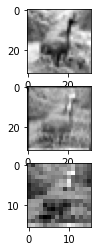

In [54]:
f, axarr = plt.subplots(3)
axarr[0].imshow(img[0].detach(), cmap='gray')
axarr[1].imshow(output_padded[0,0].detach(), cmap='gray')
axarr[2].imshow(output_pool[0,0].detach(), cmap='gray')
plt.show()
# Note that the last image is half the size of the other two, but also note that
# compared to the output of the convolution, it appears to give more weight to 
# certain aspects of the image.